In [32]:
#impost libraries
import pandas as pd
import scipy
import numpy as np

%matplotlib inline

In [33]:
# read in the CSV's
calls = pd.read_csv(r'../data/callsForServiceUpdated.csv')

C:\Users\81wingo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Clean up


In [34]:
calls = calls[calls.rptonly != True]
calls = calls[calls.cancelled != True]
print(len(calls))

1085198


In [35]:
calls['calltime'] = pd.to_datetime(calls.calltime)
calls['year'] = calls.calltime.apply(lambda x: x.date().year)
calls['month'] = calls.calltime.apply(lambda x: x.date().month)
calls['dayOfMonth'] = calls.calltime.apply(lambda x: x.date().day)
calls['hour'] = calls.calltime.apply(lambda x: x.time().hour)
calls = calls.rename(columns={'calldow' : 'dayOfWeek'})
calls = calls.drop(columns = ['timeclose', 'calltime'], axis = 1)
calls

,inci_id,parent_id,case_id,callsource,street,city,streetonly,geox,geoy,nature,...,secsar2lc,secsrt2dsp,secstr2lc,firstdisp,long,lat,year,month,dayOfMonth,hour
0,2012324665,NaN,NaN,SELF,OLD RANDLEMAN RD/COLTRANE MILL RD,G,OLD RANDLEMAN RD/COLTRANE MILL RD,1755293.88,800660.13,TRAFFIC STOP,...,651,0,0,S335,-79.826738,35.947098,2012,7,1,0
1,2012324676,NaN,1234238.0,E911,312 MARTIN LUTHER KING JR DR,G,MARTIN LUTHER KING JR DR,1767127.13,843918.75,HEMORRHAGE / LACERATIONS,...,2454,43,965,M261,-79.787921,36.066193,2012,7,1,0
2,2012324686,NaN,NaN,SELF,4525 W WENDOVER AV,G,W WENDOVER AV,1731815.63,838827.63,TRANSPORT TO ANIMAL SHELTER,...,0,0,0,ACO8,-79.907233,36.051380,2012,7,1,0
3,2012324690,NaN,1234239.0,E911,3905 BROOKHOLLOW RD,W,BROOKHOLLOW RD,1808054.75,822506.31,SEIZURES-CONVULSIONS,...,4522,30,3918,M2,-79.648974,36.008188,2012,7,1,0
4,2012324692,2.012325e+09,1206134.0,E911,3905 BROOKHOLLOW RD,W,BROOKHOLLOW RD,1808054.75,822506.31,SEIZURES-CONVULSIONS,...,900,8,0,E44,-79.648974,36.008188,2012,7,1,0
5,2012324697,NaN,1234240.0,E911,5125 MICHAUX RD,G,MICHAUX RD,1744080.88,874458.88,FALLS-BACK INJURIES(TRAUMATIC),...,0,10,0,M241,-79.866796,36.149555,2012,7,1,0
6,2012324704,NaN,1234241.0,E911,1409 DANS RD,G,DANS RD,1778039.38,840417.56,SICK PERSON,...,2295,29,1267,M211,-79.750911,36.056808,2012,7,1,0
7,2012324709,NaN,NaN,SELF,8069 HAW RIVER RD,ST,HAW RIVER RD,1709461.00,897647.69,TRAFFIC STOP,...,112,0,0,S314,-79.984825,36.212362,2012,7,1,0
8,2012324711,NaN,1234242.0,W911,WESTCHESTER DR/N MAIN ST,H,WESTCHESTER DR/N MAIN ST,1697332.38,814158.75,CHEST PAIN,...,2090,17,1323,M221,-80.023017,35.982696,2012,7,1,0
9,2012324715,NaN,NaN,PHONE,8403 MEARS FORK RD,SU,MEARS FORK RD,1759324.13,906703.25,DOMESTIC DISPUTE,...,1109,102,0,S314,-79.816067,36.238478,2012,7,1,0


In [ ]:
Drop unnecessary Columns

In [36]:
calls['actualnature'] = [x['nature2'] if x['nature'] is np.nan and x['nature'] != x['nature2'] else x['nature'] for i,x in calls.iterrows()]

In [37]:
calls.columns


Index(['inci_id', 'parent_id', 'case_id', 'callsource', 'street', 'city',
       'streetonly', 'geox', 'geoy', 'nature', 'nature2', 'priority',
       'medprior', 'meddislvl', 'rptonly', 'service', 'agency', 'district',
       'statbeat', 'ra', 'gp', 'primeunit', 'cancelled', 'closecode',
       'dayOfWeek', 'secs2rt', 'secs2di', 'secs2en', 'secs2ar', 'secs2tr',
       'secs2lc', 'secsdi2en', 'secsdi2ar', 'secsar2tr', 'secsar2lc',
       'secsrt2dsp', 'secstr2lc', 'firstdisp', 'long', 'lat', 'year', 'month',
       'dayOfMonth', 'hour', 'actualnature'],
      dtype='object')

In [38]:
calls.shape

(1085198, 45)

In [41]:
calls.priority.unique()

array(['1', '4', '9', 'P', '3', '2', '7', '5', '8', nan, '6'],
      dtype=object)

There are nan in the set so we need to get rid of those

In [43]:
calls = calls[calls['priority'].notnull()]

In [45]:
#make sure that the nan values are gone
calls.priority.unique()

array(['1', '4', '9', 'P', '3', '2', '7', '5', '8', '6'], dtype=object)

In [46]:
newdf = calls.drop(columns=['inci_id', 'parent_id', 'case_id', 'callsource', 'street', 'city',
       'streetonly', 'geox', 'geoy', 'nature', 'nature2', 'medprior', 'meddislvl', 'rptonly', 'service', 
       'statbeat', 'ra', 'gp', 'primeunit', 'cancelled', 'closecode',
       'dayOfWeek', 'secs2rt', 'secs2di', 'secs2en', 'secs2tr',
       'secs2lc', 'secsdi2en', 'secsdi2ar', 'secsar2tr', 'secsar2lc',
       'secsrt2dsp', 'secstr2lc', 'firstdisp', 'long', 'lat', 'year', 'month',
       'dayOfMonth', 'hour'])

In [47]:
#use sklearn label encoder to convert strings to numbers that can be used for calculations
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
for col in newdf.columns:
    newdf[col] = labelencoder.fit_transform(newdf[col].astype(str))
 
newdf.head(11)

,priority,agency,district,secs2ar,actualnature
0,0,3,58,0,192
1,3,1,13,9397,126
2,8,0,63,0,198
3,0,1,11,14047,173
4,9,2,0,11299,173
5,2,1,9,0,103
6,3,1,4,5985,174
7,0,3,55,1,192
8,0,1,5,6447,70
9,0,3,55,1048,86


In [48]:
newdf.columns


Index(['priority', 'agency', 'district', 'secs2ar', 'actualnature'], dtype='object')

In [49]:
newdf.describe()

,priority,agency,district,secs2ar,actualnature
count,1.084954e+06,1.084954e+06,1.084954e+06,1.084954e+06,1.084954e+06
mean,2.708889e+00,1.797061e+00,3.197515e+01,5.612920e+03,1.239234e+02
std,2.954226e+00,1.072626e+00,2.335326e+01,4.546270e+03,6.978734e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.000000e+00,7.000000e+00,1.000000e+00,6.100000e+01
50%,1.000000e+00,1.000000e+00,3.400000e+01,6.061000e+03,1.240000e+02
75%,4.000000e+00,3.000000e+00,5.700000e+01,8.979000e+03,1.920000e+02
max,9.000000e+00,3.000000e+00,6.300000e+01,1.482100e+04,2.570000e+02


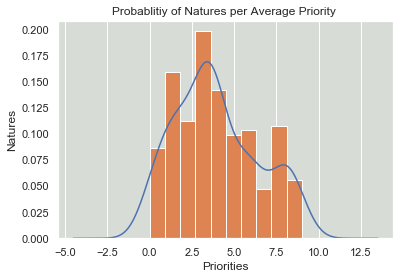

In [50]:
fig, ax = plt.subplots()
x = newdf.groupby(['actualnature'])['priority'].agg(lambda x: x.unique().mean())
x.plot.kde(ax=ax, legend=False, title = 'Probablitiy of Natures per Average Priority ')
x.plot.hist(density = True, ax = ax)
ax.set_ylabel('Natures')
ax.set_xlabel('Priorities')
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')


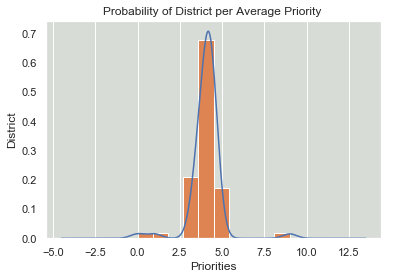

In [51]:
fig, ax = plt.subplots()
x = newdf.groupby(['district'])['priority'].agg(lambda x: x.unique().mean())
x.plot.kde(ax=ax, legend=False, title = 'Probability of District per Average Priority ')
x.plot.hist(density = True, ax = ax)
ax.set_ylabel('District')
ax.set_xlabel('Priorities')
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')

In [52]:
newdf['priority'].value_counts()

0    302044
1    253865
3    130006
2    103999
6    100373
8     78146
9     78126
4     37366
7       995
5        34
Name: priority, dtype: int64

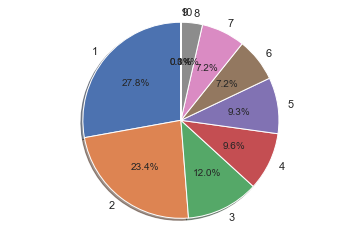

In [65]:
labels ='1', '2', '3','4', '5', '6','7', '8', '9','10'
sizes = newdf['priority'].value_counts()
 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [66]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

## Check the R Squared value to see if any of the variables can be used to conclude anything useful

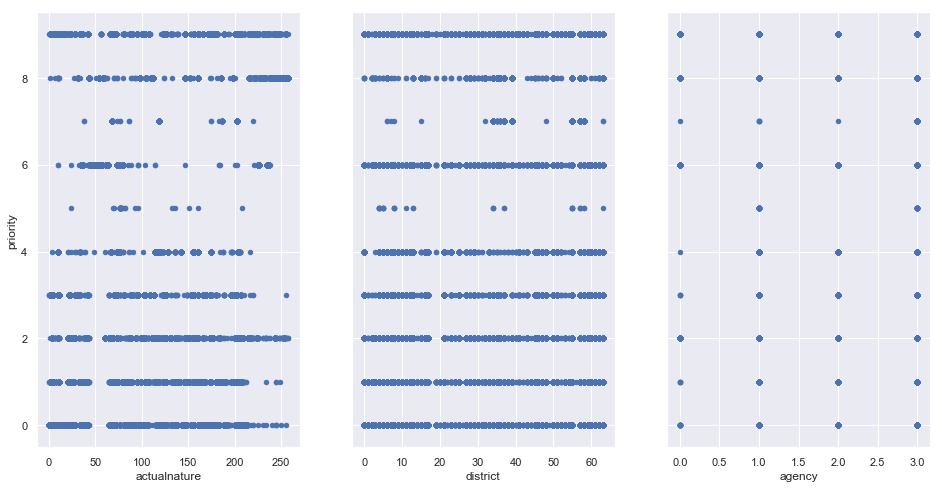

In [67]:
fig, axs = plt.subplots(1, 3, sharey=True)
newdf.plot(kind='scatter', x='actualnature', y='priority', ax=axs[0], figsize=(16, 8))
newdf.plot(kind='scatter', x='district', y='priority', ax=axs[1])
newdf.plot(kind='scatter', x='agency', y='priority', ax=axs[2])

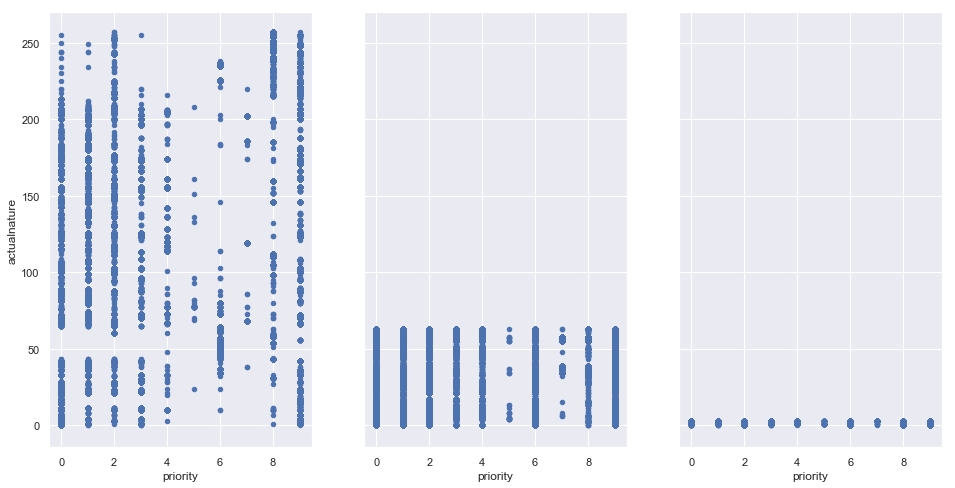

In [68]:
fig, axs = plt.subplots(1, 3, sharey=True)
newdf.plot(kind='scatter', x='priority', y='actualnature', ax=axs[0], figsize=(16, 8))
newdf.plot(kind='scatter', x='priority', y='district', ax=axs[1])
newdf.plot(kind='scatter', x='priority', y='agency', ax=axs[2])



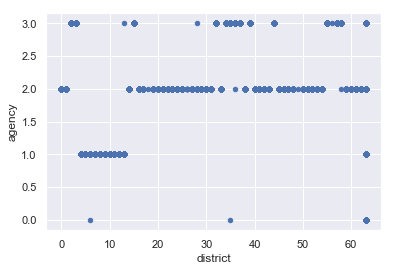

In [69]:

newdf.plot(kind='scatter', x= 'district', y ='agency')
newdf.plot(kind='scatter', x='priority', y='secs2ar', ax=axs[2])

In [70]:
import statsmodels.formula.api as smf
fitdf= smf.ols(formula = 'priority ~ district + agency + actualnature + secs2ar', data= newdf).fit()
fitdf.params

Intercept       4.706027
district        0.069916
agency         -1.515121
actualnature   -0.009563
secs2ar        -0.000058
dtype: float64

In [71]:
fitdf.rsquared

0.2597738239698696

In [72]:
fitdf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               priority   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                 9.519e+04
Date:                Wed, 28 Nov 2018   Prob (F-statistic):               0.00
Time:                        19:41:09   Log-Likelihood:            -2.5516e+06
No. Observations:             1084954   AIC:                         5.103e+06
Df Residuals:                 1084949   BIC:                         5.103e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.7060      0.009    503.754      0.000       4.688       4.724
district         0.0699      0.000    541.003      0.000       0.070       0.070
agency          -1.5151      0.003   -518.615      0.000      -1.521      -1.509
actualnature    -0.0096   3.86e-05   -247.562      0.000      -0.010      -0.009
secs2ar      -5.787e-05   5.98e-07    -96.817      0.000    -5.9e-05   -5.67e-05
==============================================================================
Omnibus:                   111111.117   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           148457.362
Skew:                           0.872   Prob(JB):                         0.00
Kurtosis:                       3.494   Cond. No.                     2.83e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [73]:
newdf.corr()

,priority,agency,district,secs2ar,actualnature
priority,1.000000,-0.202593,0.266560,-0.037335,0.010292
agency,-0.202593,1.000000,0.484994,-0.391401,-0.197476
district,0.266560,0.484994,1.000000,-0.332252,0.216524
secs2ar,-0.037335,-0.391401,-0.332252,1.000000,-0.088710
actualnature,0.010292,-0.197476,0.216524,-0.088710,1.000000


## The set is too big to use it on my personal computer I let this run for about 3 hours and it didnt finsh so i am going to do a random sampling of the data and see if i can get it execute faster
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
X = newdf.iloc[:,1:4]
y = newdf.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = preprocessing.StandardScaler()
X_train=scaler.fit_transform(X_train)

clf = svm.SVC()
clf.fit(X_train, y_train)

X_test=scaler.fit_transform(X_test)
y_predict=clf.predict(X_test)

from sklearn.metrics import accuracy_score
score=accuracy_score(y_test,y_predict)
print(score)

In [74]:
newdf.sample(n=1000, replace = False)

,priority,agency,district,secs2ar,actualnature
1123306,0,3,57,2370,24
1119168,1,1,5,10731,174
910642,0,1,9,0,156
1030523,1,3,58,9353,184
677272,0,1,8,6952,36
1104774,0,3,39,0,192
528346,1,3,58,9695,138
145939,3,3,58,7535,113
522902,6,3,35,1,46
831526,1,3,57,1556,83


In [75]:
newdf.head()

,priority,agency,district,secs2ar,actualnature
0,0,3,58,0,192
1,3,1,13,9397,126
2,8,0,63,0,198
3,0,1,11,14047,173
4,9,2,0,11299,173


In [64]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
X = newdf.iloc[:,1:4]
y = newdf.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = preprocessing.StandardScaler()
X_train=scaler.fit_transform(X_train)

regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
regression_model.score(X_train, y_train)

0.21720591125916655

In [77]:
from sklearn.model_selection import train_test_split
X = newdf
y= newdf.priority


In [78]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [79]:
from sklearn.neighbors import KNeighborsClassifier
for n_neighbors in [5, 10, 15, 20]:
# create the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# fit the model
    y_pred_knn=knn.fit(X_train, y_train)
#print each group out 
    print(n_neighbors, knn.score(X_test, y_test))

5 0.8196610002857257
10 0.7753673725832368
15 0.7507949626252354
20 0.7312365778049508


In [80]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
for n_neighbors in [2, 3, 4, 5]:
# create the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# fit the model
    y_pred_knn=knn.fit(X_train, y_train)
#print each group out 
    print(n_neighbors, knn.score(X_test, y_test))

2 0.8543812809728192
3 0.8465990961236547
4 0.8305277937367698
5 0.8196610002857257


## K-fold Cross Validation


In [81]:
from sklearn.cross_validation import cross_val_score
cv = cross_val_score(KNeighborsClassifier(2), X, y, cv=10)
print(cv)

C:\Users\81wingo\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[0.87326267 0.87688479 0.87741935 0.87939981 0.87748048 0.8789253
 0.8748652  0.87454259 0.86991548 0.84354318]


In [82]:
cv.mean()

0.8726238855381881

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train)
X_reduced = pca.transform(X)
prediction =pca.score(X_test,y_test)

from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X = newdf.iloc[:,1:4]
y = newdf.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = preprocessing.StandardScaler()
X_train=scaler.fit_transform(X_train)

clf = svm.SVC()
clf.fit(X_train, y_train)

X_test=scaler.fit_transform(X_test)
y_predict=clf.predict(X_test)

from sklearn.metrics import accuracy_score
score=accuracy_score(y_test,y_predict)
print(score)